In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Airports2.csv')

In [95]:
a = df[df['Origin_airport'] == 'YIP']['Seats'].count()
b = df[df['Destination_airport'] == 'YIP']['Seats'].count()
a+b

14460

In [91]:
freq = df['Origin_airport'].value_counts()
unique_fly = freq[freq == 1].index
# df.iloc[unique_fly]['Origin_airport']
freq[freq == max(freq)].index

Index(['ORD'], dtype='object')

In [25]:
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [29]:
df.shape

(3606803, 15)

In [26]:
df.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.599849e+06,3.599849e+06,3.599996e+06,3.599996e+06
mean,2.688910e+03,4.048297e+03,3.722890e+01,6.973190e+02,5.871502e+06,5.897982e+06,3.775029e+01,-9.186178e+01,3.774091e+01,-9.183433e+01
std,4.347617e+03,6.200871e+03,4.961970e+01,6.044165e+02,7.858062e+06,7.906127e+06,5.765453e+00,1.653773e+01,5.736556e+00,1.647228e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.090000e+02,1.560000e+02,2.000000e+00,2.730000e+02,1.030597e+06,1.025470e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.118000e+03,1.998000e+03,2.500000e+01,5.190000e+02,2.400193e+06,2.400193e+06,3.885210e+01,-8.775240e+01,3.885210e+01,-8.775240e+01
75%,3.503000e+03,5.370000e+03,5.500000e+01,9.270000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [31]:
df.isna().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [12]:
df.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

Numero di nodi (aeroporti): 727
Numero di archi (tratte): 36719


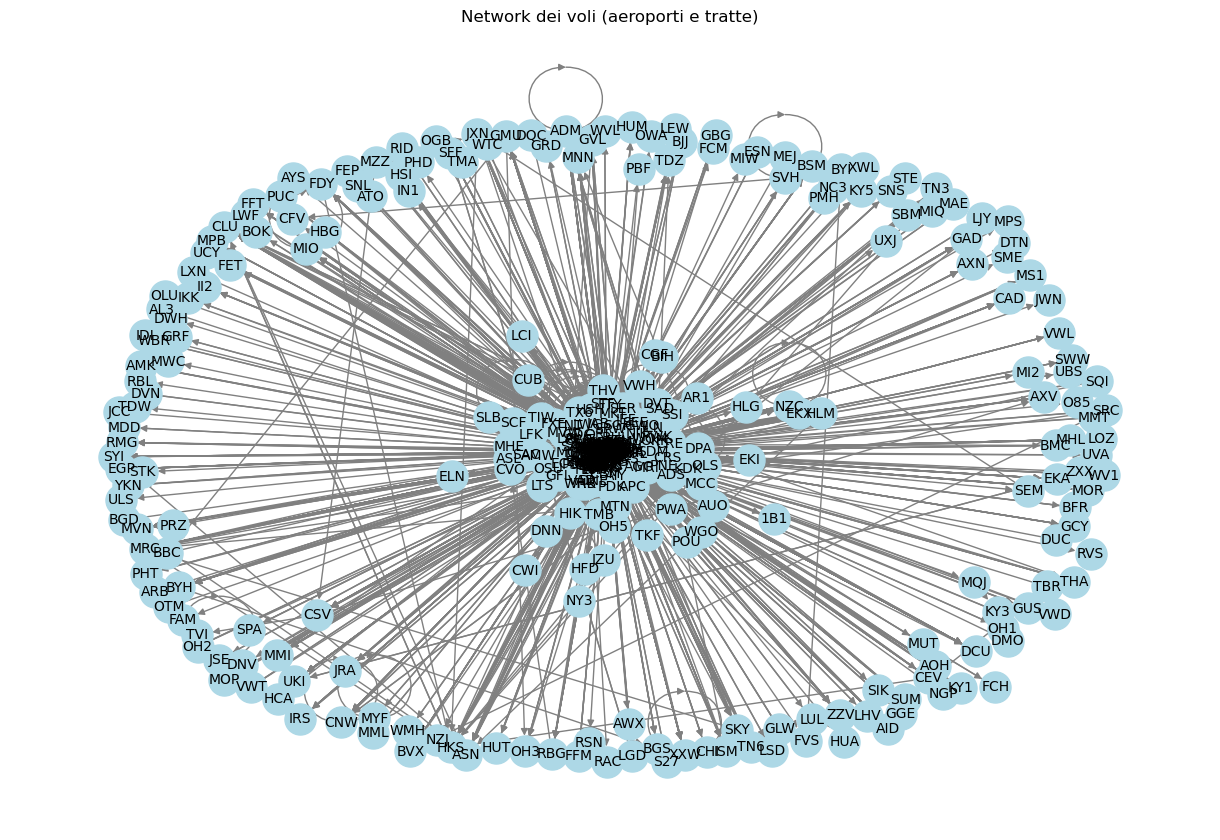

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()

origin_airports = df['Origin_airport'].unique()
destination_airports = df['Destination_airport'].unique()
all_airports = set(origin_airports).union(destination_airports)

G.add_nodes_from(all_airports)  # Aggiungi tutti gli aeroporti come nodi

# Gli archi rappresentano le tratte (Origin_airport -> Destination_airport)
treated_edges = df.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
for row in treated_edges.itertuples(index=False):
    origin = row.Origin_airport
    destination = row.Destination_airport
    passengers = row.Passengers
    G.add_edge(origin, destination, weight=passengers)  # Aggiungi l'arco con il peso


# 4. Visualizza alcune informazioni sul grafo
print(f"Numero di nodi (aeroporti): {G.number_of_nodes()}")
print(f"Numero di archi (tratte): {G.number_of_edges()}")


# 5. Visualizza il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)  # Disposizione dei nodi
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)
plt.title("Network dei voli (aeroporti e tratte)")
plt.show()

In [16]:
print(G)

DiGraph with 727 nodes and 36719 edges


# 3

In [16]:
from collections import defaultdict, deque

def calculate_betweenness_centrality(graph):
    """
    Calculate the betweenness centrality for all nodes in a graph.
    
    :param graph: Dictionary representing the graph {node: [list_of_neighbors]}.
    :return: Dictionary {node: betweenness_centrality}.
    """
    # Initialize betweenness centrality to zero for all nodes
    betweenness = {node: 0 for node in graph}

    # Iterate through each node in the graph as the source
    for source in graph:
        # Step 1: Find all shortest paths from 'source' using BFS
        stack = []  # Keeps track of the order in which nodes are explored
        paths = defaultdict(list)  # Stores all shortest paths to each node
        paths[source] = [[source]]  # Initial path from the source node to itself
        queue = deque([source])  # BFS queue
        distances = {node: float('inf') for node in graph}  # Distance from source to each node
        distances[source] = 0  # Distance to source itself is zero

        # BFS to calculate shortest paths
        while queue:
            current = queue.popleft()  # Get the next node from the queue
            stack.append(current)  # Add the node to the stack for dependency calculation

            # Explore all neighbors of the current node
            for neighbor in graph[current]:
                # If the neighbor has not been visited, update its distance and add it to the queue
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

                # If the neighbor is at the same shortest distance, add the new paths
                if distances[neighbor] == distances[current] + 1:
                    paths[neighbor].extend([path + [neighbor] for path in paths[current]])

        # Step 2: Compute dependency scores for the nodes
        dependency = {node: 0 for node in graph}

        # Process nodes in reverse order of their exploration
        while stack:
            node = stack.pop()  # Get the node from the stack
            for pred in paths[node]:
                if len(pred) > 1:  # Skip the source node itself
                    parent = pred[-2]  # Get the parent node
                    dependency[parent] += (1 + dependency[node]) / len(paths[node])

            # Update the betweenness centrality for the current node
            if node != source:
                betweenness[node] += dependency[node]

    # Normalize the betweenness centrality for undirected graphs
    normalization = 1 / ((len(graph) - 1) * (len(graph) - 2))
    for node in betweenness:
        betweenness[node] *= normalization

    return betweenness

In [17]:
betweenness_centr = calculate_betweenness_centrality(G)

In [4]:
import matplotlib.pyplot as plt

def plot_top_metric(betweenness_centrality, metric, top_n=20):
    """
    Plots the distribution of the top N nodes by betweenness centrality.
    
    :param betweenness_centrality: Dictionary {node: betweenness_centrality}.
    :param top_n: Number of top nodes to include in the histogram.
    """
    # Sort nodes by the metric in descending order
    sorted_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    # Select the top N nodes
    top_nodes = sorted_centrality[:top_n]
    
    # Extract node names and their centrality values
    nodes = [node for node, centrality in top_nodes]
    centrality_values = [centrality for node, centrality in top_nodes]
    
    # Plot the histogram
    plt.figure(figsize=(12, 6))
    plt.bar(nodes, centrality_values, color='skyblue')
    plt.xlabel("Airports (Nodes)", fontsize=14)
    plt.ylabel(f'{metric}', fontsize=14)
    plt.title(f"Top {top_n} Airports by {metric}", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

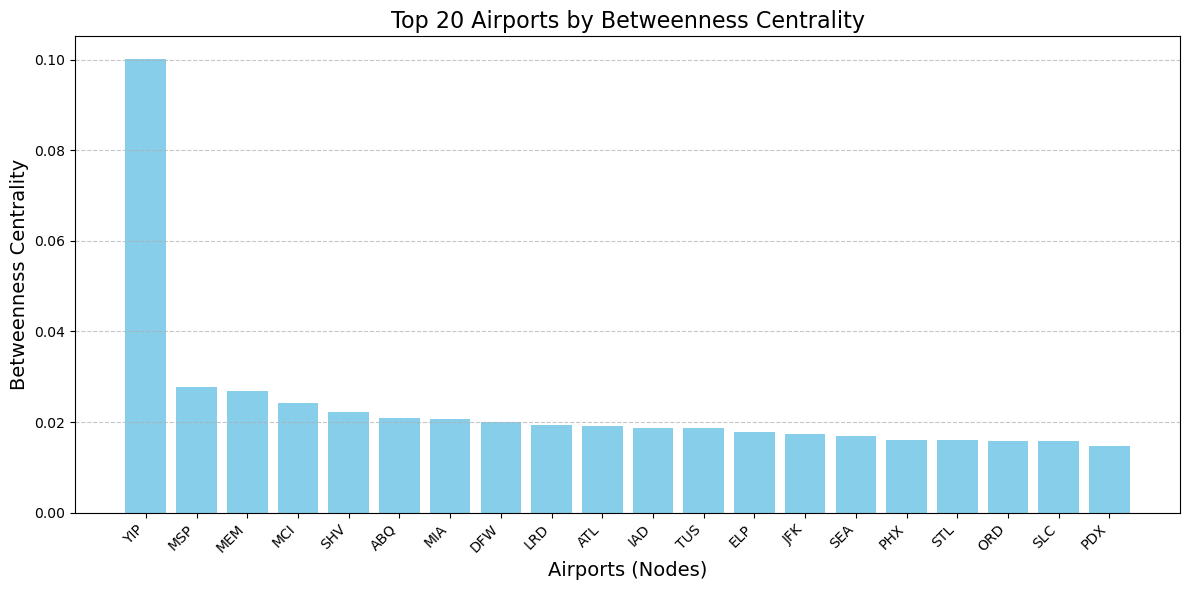

In [18]:
plot_top_metric(betweenness_centr, 'Betweenness Centrality')

In [8]:
def calculate_closeness_centrality(graph):
    """
    Calculate the closeness centrality for all nodes in a directed graph.
    The distance is measured as the number of hops (shortest paths) to each other node.
    
    :param graph: Dictionary representing the directed graph {node: [list_of_neighbors]}.
    :return: Dictionary {node: closeness_centrality}.
    """
    closeness = {}

    for source in graph:
        # Step 1: Perform BFS to find shortest paths from 'source'
        distances = {node: float('inf') for node in graph}
        distances[source] = 0
        queue = deque([source])

        while queue:
            current = queue.popleft()

            for neighbor in graph[current]:
                # If neighbor hasn't been visited, update its distance and add it to the queue
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

        # Step 2: Compute closeness centrality
        reachable_nodes = [dist for dist in distances.values() if dist != float('inf')]
        total_distance = sum(reachable_nodes)

        if total_distance > 0 and len(reachable_nodes) > 2:
            closeness[source] = (len(reachable_nodes) - 1) / total_distance
        else:
            closeness[source] = 0  # Centrality is 0 if the node is isolated or no paths exist

    return closeness

In [10]:
closeness_centrality = calculate_closeness_centrality(G)


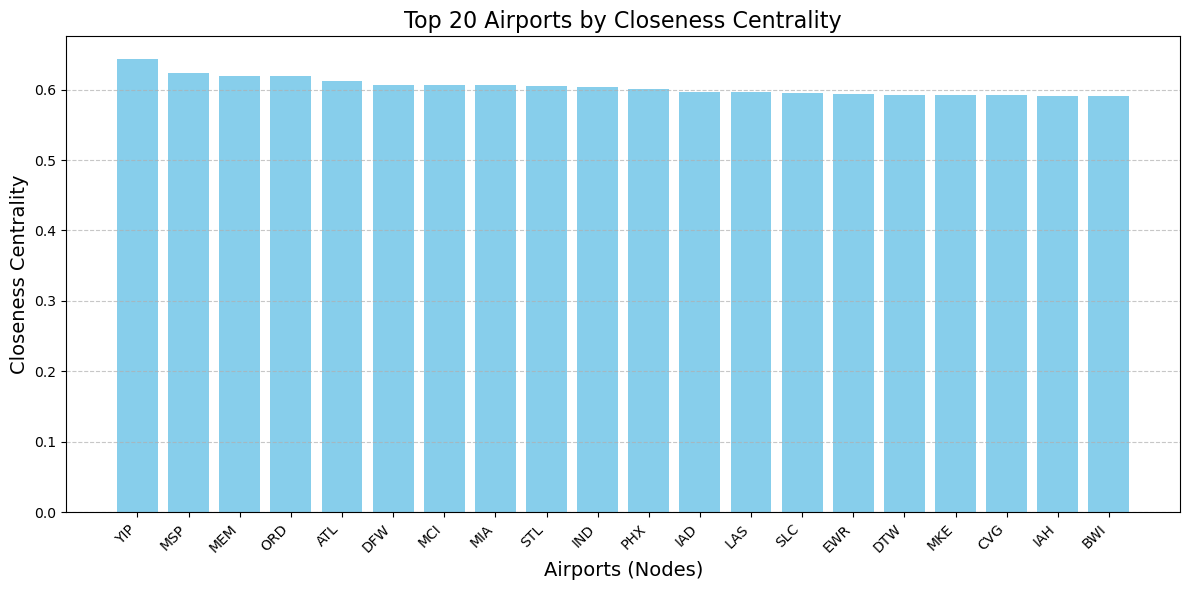

In [11]:
plot_top_metric(closeness_centrality, 'Closeness Centrality')

In [12]:
def numbers_neighbors(graph):
    """
    Calculate the out-degree (number of outgoing neighbors) for each node in a directed graph.

    :param graph: A directed graph (DiGraph object).
    :return: Dictionary {node: number_of_outgoing_neighbors}.
    """
    neighbors = {}
    for node in graph.nodes: 
        neighbors[node] = len(list(graph.successors(node)))
    
    return neighbors


In [13]:
degree_centrality = numbers_neighbors(G)

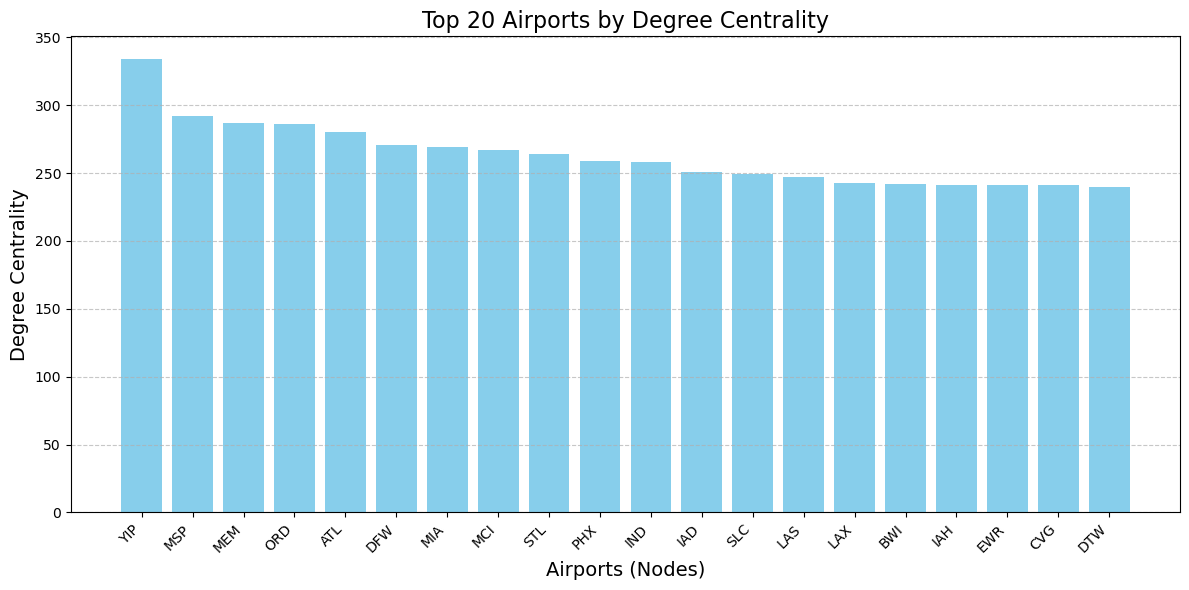

In [14]:
plot_top_metric(degree_centrality, 'Degree Centrality')

I'll use as weights the number of passengers for the moment, i'm not sure it's correct, but for PageRank makes sense, for the other 3 metrics not so much, for this reason i computed them without considering the weights.

In [25]:
def calculate_pagerank(graph, damping=0.85, max_iterations=100, tol=1.0e-6):
    """
    Compute the weighted PageRank of nodes in a directed, weighted graph.

    :param graph: Directed, weighted graph (networkx.DiGraph).
    :param damping: Damping factor (probability of following links, usually 0.85).
    :param max_iterations: Maximum number of iterations.
    :param tol: Tolerance for convergence (difference threshold).
    :return: Dictionary {node: PageRank score}.
    """
    # Initialize PageRank to 1/N for all nodes
    num_nodes = len(graph)
    pagerank = {node: 1 / num_nodes for node in graph}

    # Handle dangling nodes (nodes with no outgoing edges)
    dangling_nodes = {node for node in graph if len(graph[node]) == 0}

    for _ in range(max_iterations):
        new_pagerank = {}
        # Compute the sum of dangling node contributions
        dangling_sum = damping * sum(pagerank[node] for node in dangling_nodes) / num_nodes

        for node in graph:
            # Start with the teleportation factor
            rank_sum = (1 - damping) / num_nodes + dangling_sum

            # Add contributions from neighbors (weighted by edge weights)
            for neighbor in graph.predecessors(node):  # Use predecessors for incoming edges
                weight = graph[neighbor][node].get("weight", 1)  # Get edge weight, default is 1
                total_weight = sum(graph[neighbor][n].get("weight", 1) for n in graph.successors(neighbor))
                if total_weight != 0:
                    rank_sum += damping * (pagerank[neighbor] * weight / total_weight)
                else:
                    pass
            new_pagerank[node] = rank_sum

        # Check for convergence
        diff = sum(abs(new_pagerank[node] - pagerank[node]) for node in graph)
        if diff < tol:
            break

        pagerank = new_pagerank

    return pagerank

In [ ]:
pageranks = calculate_pagerank(G)
pageranks

{'RKS': 0.00037437276387980526,
 'MOB': 0.000737538221445203,
 'TIK': 0.000394466712345192,
 'MDT': 0.0008999012818327203,
 'FWA': 0.0005693683792275604,
 'KY3': 0.00040288959550545346,
 'IDA': 0.0004388393172224852,
 'ISN': 0.0011249036336162604,
 'IAH': 0.01593498076524243,
 'DEC': 0.0002447757618922353,
 'SPA': 0.00021777815973266786,
 'CSV': 0.00021777815973266786,
 'OLS': 0.00021777815973266786,
 'SJT': 0.00029390114963364624,
 'ELP': 0.002552696482382563,
 'EKI': 0.00021805310376746514,
 'LUL': 0.00021777815973266786,
 'MDW': 0.007670282215105453,
 'MMI': 0.00021777815973266786,
 'PUC': 0.00021777815973266786,
 'STL': 0.014966318154425173,
 'LEX': 0.00078338776188702,
 'NQA': 0.00022249277016702631,
 'AUS': 0.0039467562486724915,
 'PUB': 0.0003086814869741583,
 'AVP': 0.0004541305561269414,
 'GPT': 0.0008670663299386045,
 'BKX': 0.0003200604571577834,
 'NQX': 0.00021787500531427975,
 'SQI': 0.00021777815973266786,
 'AEX': 0.0009806977640271202,
 'SVC': 0.00021950808906300788,
 'C

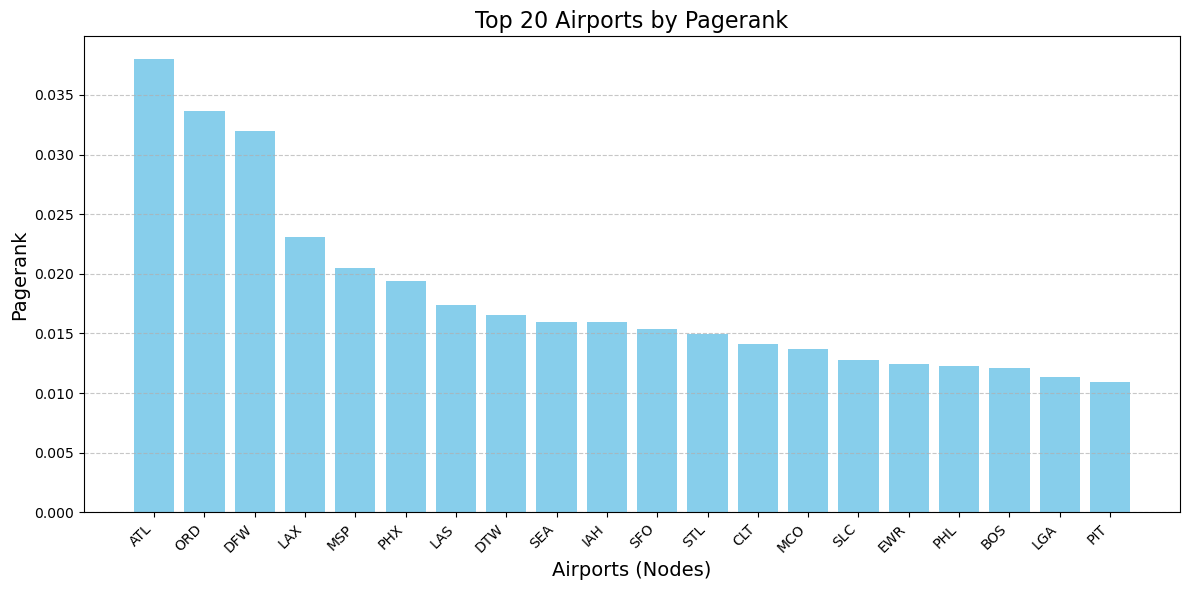

In [27]:
plot_top_metric(pageranks, 'Pagerank')

In [31]:
def analyze_centrality(betweenness_centr, closeness_centrality, degree_centrality, pageranks, airport):

    # Calculate centrality metrics
    betweenness = betweenness_centr[airport]
    closeness = closeness_centrality[airport]
    degree = degree_centrality[airport]
    pagerank = pageranks[airport]

    # organize metrics in a dataframe
    centrality_df = pd.DataFrame({
        'Airport': [airport],
        'Betweenness Centrality': [betweenness],
        'Closeness Centrality': [closeness],
        'Degree Centrality': [degree],
        'Pagerank': [pagerank]
    })
    return centrality_df

In [34]:
analyze_centrality(betweenness_centr, closeness_centrality, degree_centrality, pageranks, 'BOS')

,Airport,Betweenness Centrality,Closeness Centrality,Degree Centrality,Pagerank
0,BOS,0.012245,0.583815,228,0.012107
